In [3]:
# import necessary libraries for pytorch to train a sequence-to-sequence model using LSTM cells to generate poems of Ferdousi
# the dataset is in ferdousi.txt which is in persian
# the model is trained on a GPU

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
# # for persian
# !pip install hazm -q
# from hazm import *
import string
from collections import Counter
import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1]:
!git clone https://github.com/amnghd/Persian_poems_corpus.git
!cp Persian_poems_corpus/original/ferdousi.txt .
!rm -rf Persian_poems_corpus

Cloning into 'Persian_poems_corpus'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 45.21 MiB | 17.15 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
class FerdousiDataset(torch.utils.data.Dataset):
    def __init__(self, poem_path):
        self.poem_path = poem_path
        self.load_poem()

    def __len__(self):
        return len(self.poem)-1

    def __getitem__(self, idx):
        return self.poem[idx], self.poem[idx+1]

    def load_poem(self):
        with open(self.poem_path, 'r', encoding='utf-8') as f:
            poem = [line.strip() for line in f.readlines()]
        poem = poem[2:]
        poem = poem[:-1] if len(poem) % 2 == 1 else poem
        poem = [[poem[i], poem[i+1]] for i in range(0, len(poem), 2)]
        poem = [mesra[0] + ' ' + mesra[1] for mesra in poem]
        poem = [word_tokenize(line) for line in poem]
        punctuations = string.punctuation + '«»،؛؟'
        poem = [[word for word in line if word not in punctuations] for line in poem]
        poem = [[word for word in line if not word.isdigit()] for line in poem]
        poem = [line for line in poem if len(line) > 0]
        poem = [[word for word in line if len(word) > 1] for line in poem]
        self.max_len = max([len(line) for line in poem])
        poem = [line + ['<pad>'] * (self.max_len - len(line)) for line in poem]
        poem = [['<sos>'] + line + ['<eos>'] for line in poem]
        words = Counter([word for line in poem for word in line])
        self.word2idx = {word: idx for idx, word in enumerate(words)}
        self.idx2word = {idx: word for idx, word in enumerate(words)}
        poem = [[self.word2idx[word] for word in line] for line in poem]
        self.poem = torch.tensor(poem).long()

In [5]:
# create a dataset object
dataset = FerdousiDataset('ferdousi.txt')
# split the dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# create a dataloader for train and test
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        # x.shape = (batch_size, seq_len)
        embedding = self.embedding(x)
        # embedding.shape = (batch_size, seq_len, embedding_size)
        outputs, (hidden, cell) = self.rnn(embedding)
        # outputs.shape = (batch_size, seq_len, hidden_size)
        # hidden.shape = (num_layers, batch_size, hidden_size)
        # cell.shape = (num_layers, batch_size, hidden_size)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x, hidden, cell):
        # x.shape = (batch_size, seq_len)
        embedding = self.embedding(x)
        # embedding.shape = (batch_size, seq_len, embedding_size)
        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        # outputs.shape = (batch_size, seq_len, hidden_size)
        # hidden.shape = (num_layers, batch_size, hidden_size)
        # cell.shape = (num_layers, batch_size, hidden_size)
        predictions = self.fc(outputs)
        # predictions.shape = (batch_size, seq_len, input_size)
        return predictions, hidden, cell


In [46]:
# define a function to train the model and return the loss of the model on the train and test set
def train(encoder, decoder, train_loader, test_loader, encoder_optimizer, decoder_optimizer, criterion, num_epochs):
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        encoder.train()
        decoder.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data[:, :-1].to(device)
            target = target[:, 1:].to(device)
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            hidden, cell = encoder(data)
            predictions, _, _ = decoder(target, hidden, cell)
            loss = criterion(predictions.reshape(-1, predictions.shape[-1]), target.reshape(-1))
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        encoder.eval()
        decoder.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                data = data[:, :-1].to(device)
                target = target[:, 1:].to(device)
                hidden, cell = encoder(data)
                predictions, _, _ = decoder(target, hidden, cell)
                loss = criterion(predictions.reshape(-1, predictions.shape[-1]), target.reshape(-1))
                test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        print('Epoch: {}/{}, Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss, test_loss))
    return train_losses, test_losses
    

In [60]:
# create an encoder and decoder object
encoder = Encoder(len(dataset.word2idx), 256, 512, 3)
decoder = Decoder(len(dataset.word2idx), 256, 512, 3)
encoder = encoder.to(device)
decoder = decoder.to(device)

In [61]:
# define the optimizer and criterion
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# train the model
train_losses, test_losses = train(encoder, decoder, train_loader, test_loader, encoder_optimizer, decoder_optimizer, criterion, 4)


Epoch: 1/4, Train Loss: 2.0578, Test Loss: 0.7773
Epoch: 2/4, Train Loss: 0.4609, Test Loss: 0.3548
Epoch: 3/4, Train Loss: 0.1785, Test Loss: 0.2513
Epoch: 4/4, Train Loss: 0.0762, Test Loss: 0.2191


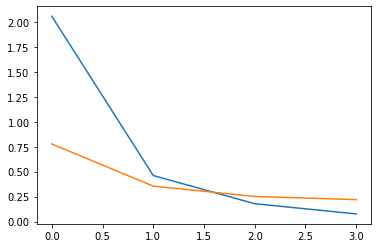

In [62]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.show()

In [63]:
# create a function called convert_to_text to convert a list of indices to a string without the <pad>, <sos>, and <eos> tokens
def convert_to_text(indices):
    text = ''
    for index in indices:
        if index == dataset.word2idx['<pad>'] or index == dataset.word2idx['<sos>'] or index == dataset.word2idx['<eos>']:
            continue
        text += dataset.idx2word[index] + ' '
    return text
    

In [64]:
# define a function to generate a given number of verses given a random verse from the dataset
def generate(encoder, decoder, num_verses):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        verse = dataset[random.randint(0, len(dataset)-1)][0]
        print(convert_to_text(verse.numpy()))
        verse = verse.unsqueeze(0).to(device)
        hidden, cell = encoder(verse)
        generated_verses = []
        for i in range(num_verses):
            generated_verse = []
            x = torch.tensor([[dataset.word2idx['<sos>']]]).to(device)
            for j in range(verse.shape[1]):
                predictions, hidden, cell = decoder(x, hidden, cell)
                predicted_index = torch.argmax(predictions, dim=2)
                generated_verse.append(predicted_index.item())
                x = predicted_index
            generated_verses.append(convert_to_text(generated_verse))
    return generated_verses
    


In [68]:
generated_verses = generate(encoder, decoder, 10)
print('Generated Verses:')
for verse in generated_verses:
    print(verse)

برآمد هر سوی دز رستخیز ندیدند جایی گذار گریز 
Generated Verses:
زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ 
زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ 
زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ 
زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ 
زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ 
زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ 
زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ 
زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ 
زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ 
زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زرسپ زر

In [69]:
# define new encoder and decoder classes like before but with Bidirectional GRU
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size)
        
    def forward(self, x):
        # x.shape = (batch_size, seq_len)
        embedding = self.embedding(x)
        # embedding.shape = (batch_size, seq_len, embedding_size)
        outputs, hidden = self.rnn(embedding)
        # outputs.shape = (batch_size, seq_len, hidden_size*2)
        # hidden.shape = (num_layers*2, batch_size, hidden_size)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        # hidden.shape = (batch_size, hidden_size)
        return hidden

class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        # x.shape = (batch_size, 1)
        # hidden.shape = (num_layers, batch_size, hidden_size)
        x = x.unsqueeze(0)
        # x.shape = (1, batch_size, 1)
        embedding = self.embedding(x)
        # embedding.shape = (1, batch_size, embedding_size)
        output, hidden = self.rnn(embedding, hidden)
        # output.shape = (1, batch_size, hidden_size)
        # hidden.shape = (num_layers, batch_size, hidden_size)
        predictions = self.fc(output)
        # predictions.shape = (1, batch_size, output_size)
        predictions = predictions.squeeze(0)
        # predictions.shape = (batch_size, output_size)
        return predictions, hidden

# define the encoder and decoder
encoder = Encoder(len(dataset.word2idx), 100, 256, 2).to(device)
decoder = Decoder(len(dataset.word2idx), 100, 256, len(dataset.word2idx), 2).to(device)

# define the optimizer and criterion
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
